# Load Data

In [1]:
from pja.umbd.projects.spd.main import SPD
from pja.umbd.projects.spd import schema
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import numpy as np

spd = SPD().dataset.data

2025-12-13 14:44:50.181 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-13 14:44:50.269 
  command:

    streamlit run /home/piotrnowakowski/Projects/pja/pja/.venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-12-13 14:44:50.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-13 14:44:50.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Select attributes

In [2]:
demographics = [schema.col.age, schema.col.gender, schema.col.race, schema.col.field_cd, schema.col.imprace]
goals = [schema.col.goal, schema.col.date]
self_perception = [schema.col.attr3_1, schema.col.sinc3_1, schema.col.intel3_1, schema.col.fun3_1, schema.col.amb3_1]
prefs = [schema.col.attr1_1, schema.col.sinc1_1, schema.col.intel1_1, schema.col.fun1_1, schema.col.amb1_1]
interests = [schema.col.sports, schema.col.exercise, schema.col.dining, schema.col.museums, schema.col.clubbing, schema.col.reading, schema.col.concerts, schema.col.yoga]
cols = [col.name for col in demographics + goals + self_perception + prefs + interests]


# Preprocessing

## Deduplicate

In [3]:
df_unique = spd.groupby('iid').first().reset_index()
df_subset = df_unique[cols].copy()
cat_cols = ['gender', 'field_cd', 'race', 'goal']
num_cols= [c for c in df_subset.columns if c not in cat_cols]

## Handle missing data

In [6]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
for col in num_cols:
    df_subset[col] = num_imputer.fit_transform(df_subset[[col]])
for col in cat_cols:
    df_subset[col] = num_imputer.fit_transform(df_subset[[col]])
  

In [7]:
print("After imputation:\n", df_subset.isnull().sum())

After imputation:
 age         0
gender      0
race        0
field_cd    0
imprace     0
goal        0
date        0
attr3_1     0
sinc3_1     0
intel3_1    0
fun3_1      0
amb3_1      0
attr1_1     0
sinc1_1     0
intel1_1    0
fun1_1      0
amb1_1      0
sports      0
exercise    0
dining      0
museums     0
clubbing    0
reading     0
concerts    0
yoga        0
dtype: int64


In [8]:
df_subset[num_cols].describe()

,age,imprace,date,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,sports,exercise,dining,museums,clubbing,reading,concerts,yoga
count,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000,551.0000
mean,26.3591,3.7335,4.9834,7.0923,8.2860,8.3856,7.7011,7.5775,22.6855,17.2908,20.1705,17.4514,10.8065,6.3952,6.2868,7.7757,6.9724,5.7518,7.6471,6.8438,4.4154
std,3.7395,2.8240,1.4578,1.3787,1.4004,1.0807,1.5348,1.7716,12.8891,7.1587,6.8351,6.1458,6.1779,2.6140,2.4343,1.7667,2.0461,2.4700,1.9901,2.1404,2.7403
min,18.0000,0.0000,1.0000,2.0000,2.0000,3.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
25%,24.0000,1.0000,4.0000,6.0000,8.0000,8.0000,7.0000,7.0000,15.0000,15.0000,17.3100,15.0000,5.0000,5.0000,5.0000,7.0000,6.0000,4.0000,7.0000,6.0000,2.0000
50%,26.0000,3.0000,5.0000,7.0000,8.2860,8.0000,8.0000,8.0000,20.0000,18.0000,20.0000,18.0000,10.0000,7.0000,7.0000,8.0000,7.0000,6.0000,8.0000,7.0000,4.0000
75%,28.0000,6.0000,6.0000,8.0000,9.0000,9.0000,9.0000,9.0000,25.0000,20.0000,22.8650,20.0000,15.0000,8.0000,8.0000,9.0000,8.0000,8.0000,9.0000,8.0000,7.0000
max,55.0000,10.0000,7.0000,10.0000,10.0000,10.0000,10.0000,10.0000,100.0000,60.0000,50.0000,50.0000,53.0000,10.0000,10.0000,10.0000,10.0000,10.0000,13.0000,10.0000,10.0000


In [9]:
corr = df_subset[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            mask=mask,
            annot=True,          # Show correlation values
            cmap='coolwarm',     # Red-blue colormap (negative/positive)
            center=0,            # Center colormap at 0
            square=True,         
            fmt='.2f',           # 2 decimal places
            cbar_kws={"shrink": .8},
            linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()

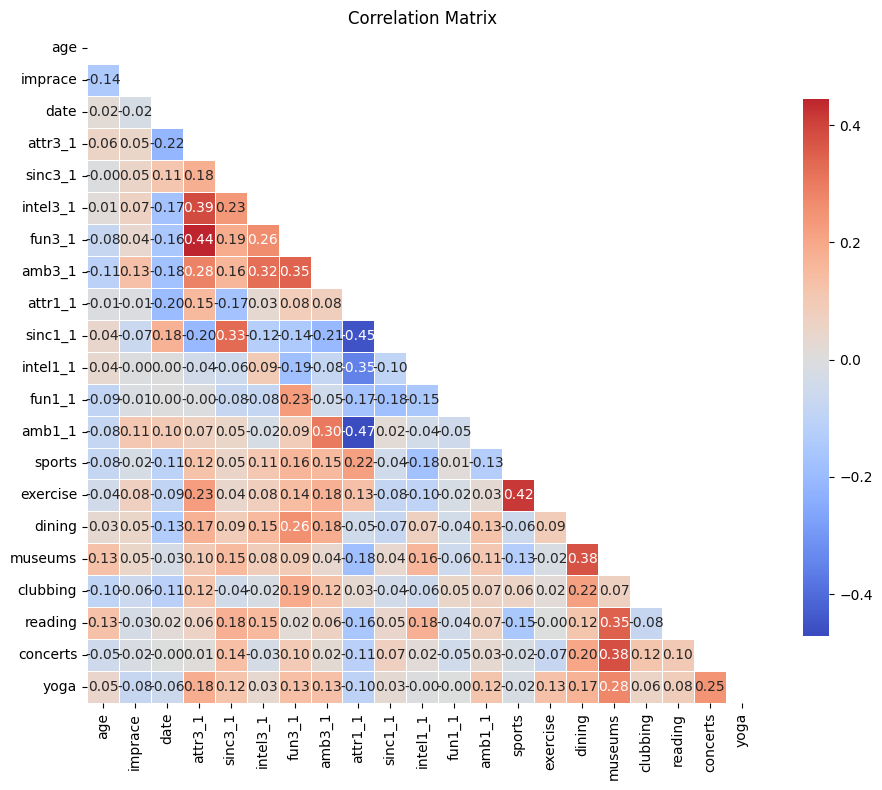

In [10]:
%matplotlib inline
plt.show()

## Encode categorical variables

In [11]:
df_subset[cat_cols].describe()

,gender,field_cd,race,goal
count,551.0000,551.0000,551.0000,551.0000
mean,0.5027,7.5496,2.8000,2.1489
std,0.5004,3.7486,1.2470,1.4390
min,0.0000,1.0000,1.0000,1.0000
25%,0.0000,5.0000,2.0000,1.0000
50%,1.0000,8.0000,2.0000,2.0000
75%,1.0000,10.0000,4.0000,2.0000
max,1.0000,18.0000,6.0000,6.0000


In [12]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [13]:
encoded_cats =encoder.fit_transform(df_subset[cat_cols])                                     

In [14]:
cat_cols

['gender', 'field_cd', 'race', 'goal']

In [15]:
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(cat_cols)
)

In [16]:
df_ready = pd.concat([
    df_subset[num_cols].reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)

In [17]:
df_ready

,age,imprace,date,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,sports,exercise,dining,museums,clubbing,reading,concerts,yoga,gender_0.0,gender_1.0,field_cd_1.0,field_cd_2.0,field_cd_3.0,field_cd_4.0,field_cd_5.0,field_cd_6.0,field_cd_7.0,field_cd_7.549632352941177,field_cd_8.0,field_cd_9.0,field_cd_10.0,field_cd_11.0,field_cd_12.0,field_cd_13.0,field_cd_14.0,field_cd_15.0,field_cd_16.0,field_cd_17.0,field_cd_18.0,race_1.0,race_2.0,race_2.8,race_3.0,race_4.0,race_6.0,goal_1.0,goal_2.0,goal_2.1488970588235294,goal_3.0,goal_4.0,goal_5.0,goal_6.0
0,21.0000,2.0000,7.0000,6.0000,8.0000,8.0000,8.0000,7.0000,15.0000,20.0000,20.0000,15.0000,15.0000,9.0000,8.0000,9.0000,1.0000,5.0000,6.0000,10.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,24.0000,2.0000,5.0000,7.0000,5.0000,8.0000,10.0000,3.0000,45.0000,5.0000,25.0000,20.0000,0.0000,3.0000,7.0000,10.0000,8.0000,8.0000,10.0000,7.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,25.0000,8.0000,3.0000,8.0000,9.0000,9.0000,8.0000,8.0000,35.0000,10.0000,35.0000,10.0000,10.0000,3.0000,7.0000,8.0000,5.0000,5.0000,7.0000,7.0000,7.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,23.0000,1.0000,5.0000,7.0000,8.0000,7.0000,9.0000,8.0000,20.0000,20.0000,20.0000,20.0000,10.0000,1.0000,6.0000,7.0000,6.0000,7.0000,7.0000,8.0000,8.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,21.0000,8.0000,4.0000,6.0000,3.0000,10.0000,6.0000,8.0000,20.0000,5.0000,25.0000,25.0000,10.0000,7.0000,7.0000,7.0000,6.0000,8.0000,6.0000,3.0000,3.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,30.0000,8.0000,6.0000,10.0000,10.0000,10.0000,10.0000,10.0000,40.0000,10.0000,20.0000,10.0000,0.0000,10.0000,4.0000,10.0000,3.0000,1.0000,9.0000,7.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
547,28.0000,2.0000,7.0000,7.0000,10.0000,9.0000,8.0000,9.0000,20.0000,20.0000,20.0000,20.0000,0.0000,8.0000,6.0000,9.0000,7.0000,8.0000,7.0000,10.0000,2.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
548,30.0000,5.0000,4.0000,7.0000,7.0000,7.0000,7.0000,7.0000,30.0000,3.0000,30.0000,30.0000,3.0000,5.0000,5.0000,9.0000,7.0000,8.0000,8.0000,4.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
549,27.0000,2.0000,6.0000,7.0000,8.00

# Clustering


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

In [19]:
X = df_ready.values

In [20]:
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")


PCA explained variance: 59.3%


array([[ -8.20067692,   2.20919596],
       [ 24.91264077, -11.08493827],
       [ 11.02550264, -13.02379128],
       ...,
       [  9.67051298, -18.29655115],
       [ 17.4005915 ,   3.4247489 ],
       [ 51.3739422 ,  -5.82965351]], shape=(551, 2))

In [21]:
# 2. t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_2d = tsne.fit_transform(X)

# 3. DBSCAN (very robust on this dataset)
db = DBSCAN(eps=2.2, min_samples=5)          # these values work great on the scaled data
db_labels = db.fit_predict(X)
print(f"DBSCAN found {len(set(db_labels)) - (1 if -1 in db_labels else 0)} clusters + noise")

# 4. K-means (for comparison)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)
km_labels = kmeans.fit_predict(X)

DBSCAN found 1 clusters + noise


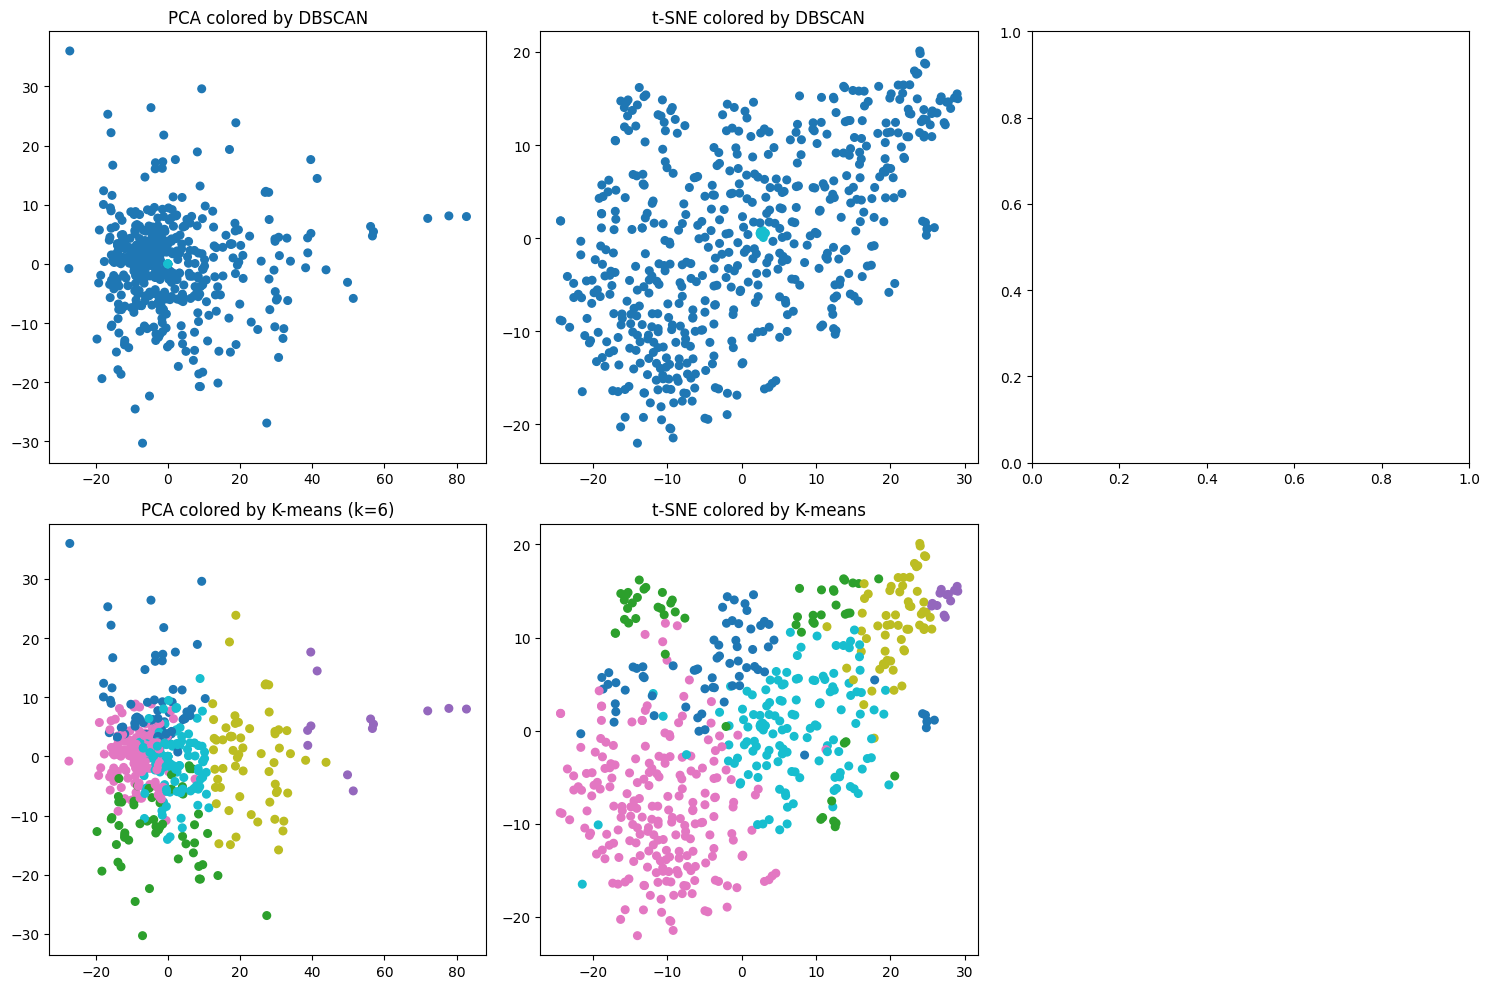

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0,0].scatter(pca_2d[:,0], pca_2d[:,1], c=db_labels, cmap='tab10', s=30)
axs[0,0].set_title('PCA colored by DBSCAN')

axs[0,1].scatter(tsne_2d[:,0], tsne_2d[:,1], c=db_labels, cmap='tab10', s=30)
axs[0,1].set_title('t-SNE colored by DBSCAN')


axs[1,0].scatter(pca_2d[:,0], pca_2d[:,1], c=km_labels, cmap='tab10', s=30)
axs[1,0].set_title('PCA colored by K-means (k=6)')

axs[1,1].scatter(tsne_2d[:,0], tsne_2d[:,1], c=km_labels, cmap='tab10', s=30)
axs[1,1].set_title('t-SNE colored by K-means')

axs[1,2].axis('off')
plt.tight_layout()
plt.show()

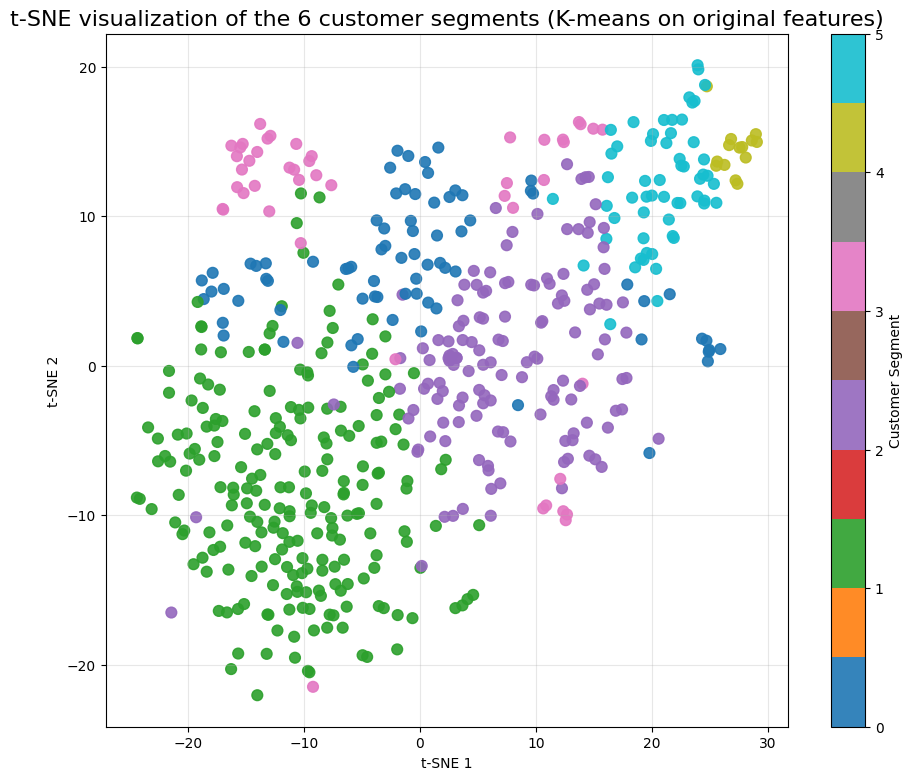

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit K-means on the ORIGINAL scaled data (this is your gold standard)
k = 6                                      # try 5, 6, 7, 8 and pick the one that looks best on t-SNE
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
final_labels = kmeans.fit_predict(X)   # ← THESE are your real customer segments

# 2. Add the labels back to your original readable dataframe
df_original = spd.groupby('iid').first().reset_index()      # raw human-readable data
df_original['customer_segment'] = final_labels

# 3. Create the beautiful t-SNE plot colored by the REAL labels
plt.figure(figsize=(11, 9))
scatter = plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                      c=final_labels, 
                      cmap='tab10', 
                      s=60, 
                      alpha=0.9)
plt.title(f"t-SNE visualization of the {k} customer segments (K-means on original features)", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label='Customer Segment')
plt.grid(True, alpha=0.3)
plt.show()

## Make it human readable

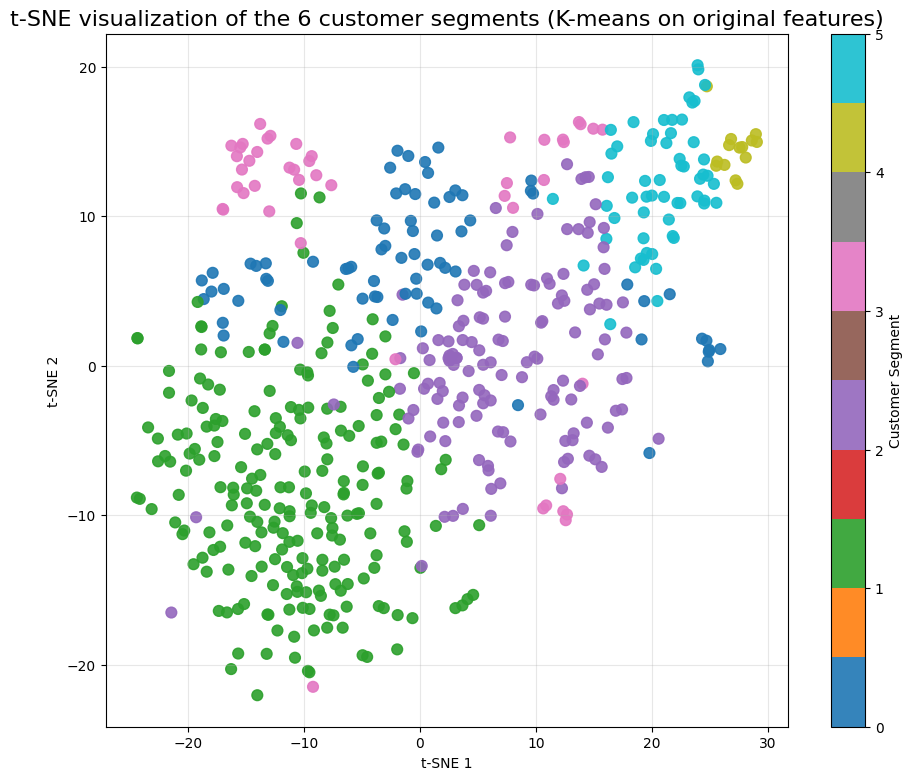

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit K-means on the ORIGINAL scaled data (this is your gold standard)
k = 6                                      # try 5, 6, 7, 8 and pick the one that looks best on t-SNE
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
final_labels = kmeans.fit_predict(X)   # ← THESE are your real customer segments

# 2. Add the labels back to your original readable dataframe
df_original = spd.groupby('iid').first().reset_index()      # raw human-readable data
df_original['customer_segment'] = final_labels

# 3. Create the beautiful t-SNE plot colored by the REAL labels
plt.figure(figsize=(11, 9))
scatter = plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                      c=final_labels, 
                      cmap='tab10', 
                      s=60, 
                      alpha=0.9)
plt.title(f"t-SNE visualization of the {k} customer segments (K-means on original features)", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label='Customer Segment')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# This table is what you copy-paste into your report / slide deck
profile = df_original.groupby('customer_segment').agg({
    'age': 'mean',
    'gender': lambda x: f"{(x.mean()*100):.0f}% male",
    'goal': lambda x: x.mode()[0],
    'attr1_1': 'mean',      # importance of attractiveness
    'sinc1_1': 'mean',
    'intel1_1': 'mean',
    'amb1_1': 'mean',
    'shar1_1': 'mean',
    'imprace': 'mean',
    'clubbing': 'mean',
    'sports': 'mean',
    'field_cd': lambda x: x.mode()[0]
}).round(1)

profile = profile.rename(columns={
    'attr1_1': 'Looks_importance',
    'sinc1_1': 'Sincerity_importance',
    'goal': 'Most_common_goal',
    'imprace': 'Same_race_importance'
})

profile.T

customer_segment,0,1,2,3,4,5
age,27.3000,26.4000,26.0000,25.9000,25.8000,26.4000
gender,55% male,32% male,66% male,41% male,86% male,77% male
Most_common_goal,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Looks_importance,21.0000,15.3000,23.5000,17.5000,72.4000,43.6000
Sincerity_importance,27.4000,18.3000,15.6000,12.2000,6.3000,10.7000
intel1_1,20.1000,19.1000,20.0000,33.4000,6.1000,17.5000
amb1_1,6.3000,16.1000,8.3000,9.7000,2.4000,4.8000
shar1_1,12.5000,13.9000,10.5000,12.4000,3.2000,7.4000
Same_race_importance,3.0000,4.1000,3.6000,3.7000,3.3000,3.9000
clubbing,5.0000,5.9000,6.2000,4.9000,6.1000,5.8000


/home/piotrnowakowski/Projects/pja/pja/.venv/lib/python3.12/site-packages/sweetviz/graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


                                             | | [  0%]   00:00 -> (? left)

AttributeError: module 'numpy' has no attribute 'VisibleDeprecationWarning'

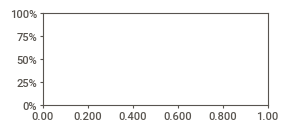

In [26]:
import sweetviz as sv
analysis = sv.analyze(df_ready)